# CHM Exploration: Barro Colorado Island

**Site:** Barro Colorado Island, Panama  
**Forest Type:** Tropical Moist Forest (Neotropical Lowland Rainforest)  
**Data Source:** [Smithsonian ALS Panama 2023](https://smithsonian.dataone.org/datasets/ALS_Panama_2023/03_Barro_Colorado_Island/)  
**Resolution:** 0.5m (matches 3DEP framework standard)

## Objectives

1. Load and visualize the whole-island CHM
2. Calculate summary statistics (min/max/mean/median canopy height)
3. Analyze height distribution with histograms and percentiles
4. Identify data quality issues (NoData areas, artifacts)
5. Generate overview maps and metadata

**Note:** Unlike 3DEP workflows that generate CHM from point clouds, BCI provides pre-computed CHM at 0.5m resolution, enabling direct analysis.

## 1. Environment Setup

In [1]:
# Environment validation
import sys

REQUIRED_PACKAGES = ['rioxarray', 'geopandas', 'numpy', 'matplotlib', 'scipy']
missing = []

for pkg in REQUIRED_PACKAGES:
    try:
        __import__(pkg)
    except ImportError:
        missing.append(pkg)

if missing:
    raise ImportError(
        f"Missing packages: {missing}\n"
        f"Please activate the 3dep conda environment:\n"
        f"  conda activate 3dep"
    )

print("Environment validated successfully!")

Environment validated successfully!


In [2]:
# Import libraries
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
from scipy import stats as scipy_stats
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from rasterio.enums import Resampling
import rasterio

# For COG validation (optional)
try:
    from rio_cogeo.cogeo import cog_validate
    from osgeo import gdal
    HAS_COG_TOOLS = True
except ImportError:
    HAS_COG_TOOLS = False

print(f"Libraries loaded at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"COG validation tools available: {HAS_COG_TOOLS}")

Libraries loaded at 2025-12-24 23:17:13
COG validation tools available: True


## 2. Configuration

In [3]:
# Site configuration
SITE_NAME = "bci_panama"
SITE_DESCRIPTION = "Barro Colorado Island, Panama - Tropical Moist Forest"

# Data paths
DATA_BASE = Path.home() / "data-store/data/output/smithsonian"
RAW_DATA = DATA_BASE / "raw"
PROCESSED_DATA = DATA_BASE / "processed"
ANALYSIS_DATA = DATA_BASE / "analysis"

# Input files (pre-downloaded from Smithsonian)
CHM_PATH = RAW_DATA / "chm" / "BCI_whole_2023_05_26_chm.tif"
DTM_PATH = RAW_DATA / "dtm" / "BCI_whole_2023_05_26_dtm.tif"
DSM_PATH = RAW_DATA / "dsm" / "BCI_whole_2023_05_26_dsm.tif"

# Output directories
OUTPUT_DIR = ANALYSIS_DATA / "chm_exploration"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Verify input files exist
print("Input files:")
for name, path in [("CHM", CHM_PATH), ("DTM", DTM_PATH), ("DSM", DSM_PATH)]:
    exists = path.exists()
    size = f"{path.stat().st_size / 1e9:.2f} GB" if exists else "NOT FOUND"
    status = "OK" if exists else "MISSING"
    print(f"  [{status}] {name}: {path.name} ({size})")

print(f"\nOutput directory: {OUTPUT_DIR}")

Input files:
  [OK] CHM: BCI_whole_2023_05_26_chm.tif (1.14 GB)
  [OK] DTM: BCI_whole_2023_05_26_dtm.tif (1.14 GB)
  [OK] DSM: BCI_whole_2023_05_26_dsm.tif (1.14 GB)

Output directory: /home/jovyan/data-store/data/output/smithsonian/analysis/chm_exploration


## 3. Load CHM Data

In [4]:
# Load the CHM raster
print(f"Loading CHM from: {CHM_PATH.name}")
print("This may take a moment for the 1.1 GB file...")

chm = rxr.open_rasterio(CHM_PATH, masked=True)

print(f"\nCHM loaded successfully!")
print(f"  Shape: {chm.shape}")
print(f"  CRS: {chm.rio.crs}")
print(f"  Resolution: {abs(chm.rio.resolution()[0]):.2f}m x {abs(chm.rio.resolution()[1]):.2f}m")
print(f"  Bounds: {chm.rio.bounds()}")
print(f"  NoData value: {chm.rio.nodata}")

Loading CHM from: BCI_whole_2023_05_26_chm.tif
This may take a moment for the 1.1 GB file...

CHM loaded successfully!
  Shape: (1, 11000, 13000)
  CRS: EPSG:32617
  Resolution: 0.50m x 0.50m
  Bounds: (623500.0, 1009500.0, 630000.0, 1015000.0)
  NoData value: nan


In [5]:
# Calculate spatial extent
bounds = chm.rio.bounds()
width_m = bounds[2] - bounds[0]
height_m = bounds[3] - bounds[1]
area_km2 = (width_m * height_m) / 1e6

print("Spatial Extent:")
print(f"  Width:  {width_m:.1f} m ({width_m/1000:.2f} km)")
print(f"  Height: {height_m:.1f} m ({height_m/1000:.2f} km)")
print(f"  Area:   {area_km2:.2f} km²")
print(f"\n  Note: BCI is approximately 15.6 km² - this includes surrounding water/buffer")

Spatial Extent:
  Width:  6500.0 m (6.50 km)
  Height: 5500.0 m (5.50 km)
  Area:   35.75 km²

  Note: BCI is approximately 15.6 km² - this includes surrounding water/buffer


## 4. CHM Statistics

In [6]:
# Extract valid height values
print("Extracting valid height values...")

# Flatten and remove NoData/NaN
chm_data = chm.values.flatten()
chm_valid = chm_data[~np.isnan(chm_data)]

# Remove NoData value if set
if chm.rio.nodata is not None:
    chm_valid = chm_valid[chm_valid != chm.rio.nodata]

print(f"  Total pixels: {len(chm_data):,}")
print(f"  Valid pixels: {len(chm_valid):,}")
print(f"  NoData pixels: {len(chm_data) - len(chm_valid):,}")
print(f"  Data coverage: {100 * len(chm_valid) / len(chm_data):.1f}%")

Extracting valid height values...
  Total pixels: 143,000,000
  Valid pixels: 85,420,424
  NoData pixels: 57,579,576
  Data coverage: 59.7%


In [7]:
# Filter to reasonable canopy height values (0-80m for tropical forest)
# BCI emergent trees can reach ~50m, so 80m is a safe upper bound
HEIGHT_MIN = 0
HEIGHT_MAX = 80  # Conservative upper bound for tropical forest

chm_heights = chm_valid[(chm_valid >= HEIGHT_MIN) & (chm_valid <= HEIGHT_MAX)]

# Check for negative values (potential artifacts)
negative_count = np.sum(chm_valid < 0)
extreme_high = np.sum(chm_valid > HEIGHT_MAX)

print(f"Height filtering ({HEIGHT_MIN}m to {HEIGHT_MAX}m):")
print(f"  Valid height pixels: {len(chm_heights):,}")
print(f"  Negative values (artifacts): {negative_count:,}")
print(f"  Extreme high values (>{HEIGHT_MAX}m): {extreme_high:,}")

Height filtering (0m to 80m):
  Valid height pixels: 73,645,174
  Negative values (artifacts): 11,775,250
  Extreme high values (>80m): 0


In [8]:
# Calculate comprehensive statistics
print("="*60)
print("CHM STATISTICS - Barro Colorado Island")
print("="*60)

stats = {
    'site_name': SITE_NAME,
    'site_description': SITE_DESCRIPTION,
    'source_file': CHM_PATH.name,
    'resolution_m': abs(chm.rio.resolution()[0]),
    'crs': str(chm.rio.crs),
    'bounds': list(chm.rio.bounds()),
    'area_km2': area_km2,
    'pixel_counts': {
        'total': int(len(chm_data)),
        'valid': int(len(chm_valid)),
        'valid_heights': int(len(chm_heights)),
        'nodata': int(len(chm_data) - len(chm_valid)),
        'negative': int(negative_count),
        'extreme_high': int(extreme_high)
    },
    'height_statistics': {
        'min_m': float(np.min(chm_heights)),
        'max_m': float(np.max(chm_heights)),
        'mean_m': float(np.mean(chm_heights)),
        'median_m': float(np.median(chm_heights)),
        'std_m': float(np.std(chm_heights)),
        'variance_m2': float(np.var(chm_heights)),
        'skewness': float(scipy_stats.skew(chm_heights)),
        'kurtosis': float(scipy_stats.kurtosis(chm_heights))
    },
    'percentiles': {
        'p10': float(np.percentile(chm_heights, 10)),
        'p25': float(np.percentile(chm_heights, 25)),
        'p50': float(np.percentile(chm_heights, 50)),
        'p75': float(np.percentile(chm_heights, 75)),
        'p90': float(np.percentile(chm_heights, 90)),
        'p95': float(np.percentile(chm_heights, 95)),
        'p99': float(np.percentile(chm_heights, 99))
    },
    'generated_at': datetime.now().isoformat(),
    'data_source': 'Smithsonian ALS Panama 2023'
}

# Display key statistics
print(f"\nBasic Statistics:")
print(f"  Min height:    {stats['height_statistics']['min_m']:.2f} m")
print(f"  Max height:    {stats['height_statistics']['max_m']:.2f} m")
print(f"  Mean height:   {stats['height_statistics']['mean_m']:.2f} m")
print(f"  Median height: {stats['height_statistics']['median_m']:.2f} m")
print(f"  Std deviation: {stats['height_statistics']['std_m']:.2f} m")

print(f"\nDistribution Shape:")
print(f"  Skewness:      {stats['height_statistics']['skewness']:.3f}")
print(f"  Kurtosis:      {stats['height_statistics']['kurtosis']:.3f}")

print(f"\nPercentiles:")
print(f"  P10:  {stats['percentiles']['p10']:.2f} m")
print(f"  P25:  {stats['percentiles']['p25']:.2f} m")
print(f"  P50:  {stats['percentiles']['p50']:.2f} m (median)")
print(f"  P75:  {stats['percentiles']['p75']:.2f} m")
print(f"  P90:  {stats['percentiles']['p90']:.2f} m")
print(f"  P95:  {stats['percentiles']['p95']:.2f} m")
print(f"  P99:  {stats['percentiles']['p99']:.2f} m (near-maximum emergents)")

CHM STATISTICS - Barro Colorado Island

Basic Statistics:
  Min height:    0.00 m
  Max height:    72.67 m
  Mean height:   18.70 m
  Median height: 19.66 m
  Std deviation: 11.40 m

Distribution Shape:
  Skewness:      -0.190
  Kurtosis:      -0.830

Percentiles:
  P10:  0.01 m
  P25:  11.29 m
  P50:  19.66 m (median)
  P75:  27.37 m
  P90:  32.97 m
  P95:  35.93 m
  P99:  40.92 m (near-maximum emergents)


## 5. Height Distribution Analysis

Height distribution saved to: bci_panama_height_distribution.png


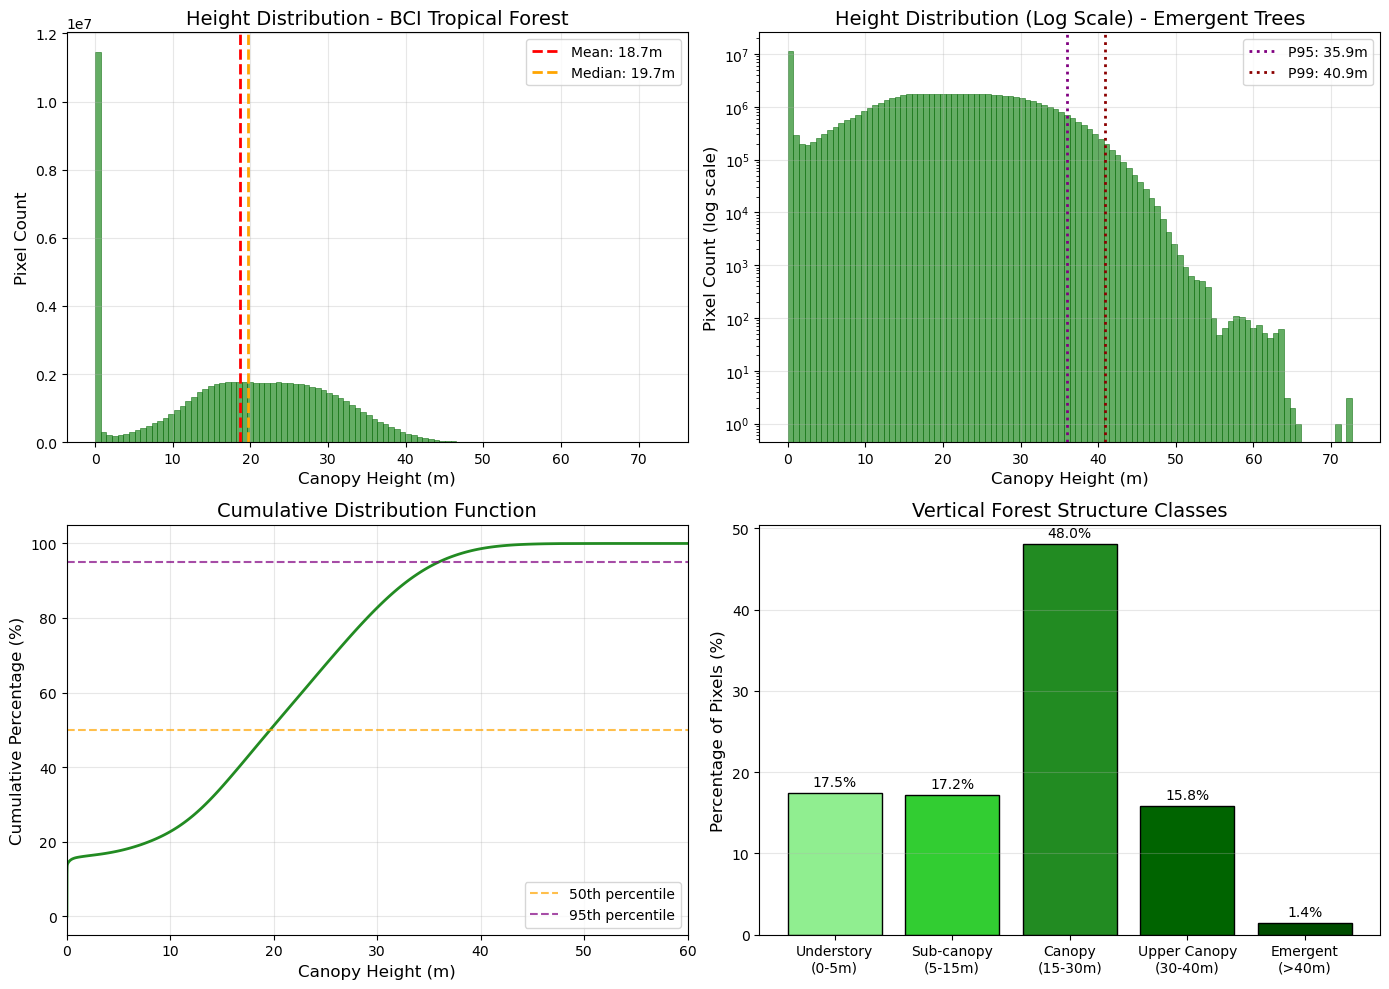

In [9]:
# Create height distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Main histogram
ax1 = axes[0, 0]
ax1.hist(chm_heights, bins=100, color='forestgreen', alpha=0.7, edgecolor='darkgreen', linewidth=0.5)
ax1.axvline(stats['height_statistics']['mean_m'], color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {stats['height_statistics']['mean_m']:.1f}m")
ax1.axvline(stats['height_statistics']['median_m'], color='orange', linestyle='--', linewidth=2,
            label=f"Median: {stats['height_statistics']['median_m']:.1f}m")
ax1.set_xlabel('Canopy Height (m)', fontsize=12)
ax1.set_ylabel('Pixel Count', fontsize=12)
ax1.set_title('Height Distribution - BCI Tropical Forest', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. Log-scale histogram (to see rare tall trees)
ax2 = axes[0, 1]
ax2.hist(chm_heights, bins=100, color='forestgreen', alpha=0.7, edgecolor='darkgreen', linewidth=0.5)
ax2.set_yscale('log')
ax2.axvline(stats['percentiles']['p95'], color='purple', linestyle=':', linewidth=2,
            label=f"P95: {stats['percentiles']['p95']:.1f}m")
ax2.axvline(stats['percentiles']['p99'], color='darkred', linestyle=':', linewidth=2,
            label=f"P99: {stats['percentiles']['p99']:.1f}m")
ax2.set_xlabel('Canopy Height (m)', fontsize=12)
ax2.set_ylabel('Pixel Count (log scale)', fontsize=12)
ax2.set_title('Height Distribution (Log Scale) - Emergent Trees', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution
ax3 = axes[1, 0]
sorted_heights = np.sort(chm_heights)
cumulative = np.arange(1, len(sorted_heights) + 1) / len(sorted_heights) * 100
ax3.plot(sorted_heights, cumulative, color='forestgreen', linewidth=2)
ax3.axhline(50, color='orange', linestyle='--', alpha=0.7, label='50th percentile')
ax3.axhline(95, color='purple', linestyle='--', alpha=0.7, label='95th percentile')
ax3.set_xlabel('Canopy Height (m)', fontsize=12)
ax3.set_ylabel('Cumulative Percentage (%)', fontsize=12)
ax3.set_title('Cumulative Distribution Function', fontsize=14)
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 60)

# 4. Box plot with height classes
ax4 = axes[1, 1]
# Create height classes for tropical forest structure
height_classes = {
    'Understory\n(0-5m)': chm_heights[(chm_heights >= 0) & (chm_heights < 5)],
    'Sub-canopy\n(5-15m)': chm_heights[(chm_heights >= 5) & (chm_heights < 15)],
    'Canopy\n(15-30m)': chm_heights[(chm_heights >= 15) & (chm_heights < 30)],
    'Upper Canopy\n(30-40m)': chm_heights[(chm_heights >= 30) & (chm_heights < 40)],
    'Emergent\n(>40m)': chm_heights[chm_heights >= 40]
}

class_counts = [len(v) for v in height_classes.values()]
class_pcts = [100 * c / len(chm_heights) for c in class_counts]
colors = ['#90EE90', '#32CD32', '#228B22', '#006400', '#004d00']

bars = ax4.bar(height_classes.keys(), class_pcts, color=colors, edgecolor='black')
ax4.set_ylabel('Percentage of Pixels (%)', fontsize=12)
ax4.set_title('Vertical Forest Structure Classes', fontsize=14)
ax4.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, pct in zip(bars, class_pcts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Save figure
hist_path = OUTPUT_DIR / f"{SITE_NAME}_height_distribution.png"
plt.savefig(hist_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"Height distribution saved to: {hist_path.name}")

plt.show()

In [10]:
# Print forest structure analysis
print("="*60)
print("VERTICAL FOREST STRUCTURE ANALYSIS")
print("="*60)

for class_name, heights in height_classes.items():
    pct = 100 * len(heights) / len(chm_heights)
    if len(heights) > 0:
        mean_h = np.mean(heights)
        print(f"\n{class_name.replace(chr(10), ' ')}:")
        print(f"  Pixels: {len(heights):,} ({pct:.1f}%)")
        print(f"  Mean height: {mean_h:.2f} m")
    else:
        print(f"\n{class_name.replace(chr(10), ' ')}: 0 pixels")

VERTICAL FOREST STRUCTURE ANALYSIS

Understory (0-5m):
  Pixels: 12,882,082 (17.5%)
  Mean height: 0.35 m

Sub-canopy (5-15m):
  Pixels: 12,685,625 (17.2%)
  Mean height: 11.30 m

Canopy (15-30m):
  Pixels: 35,380,737 (48.0%)
  Mean height: 22.37 m

Upper Canopy (30-40m):
  Pixels: 11,655,535 (15.8%)
  Mean height: 33.76 m

Emergent (>40m):
  Pixels: 1,041,195 (1.4%)
  Mean height: 42.37 m


## 6. CHM Visualization

In [11]:
# Downsample for visualization (1.1GB is too large to plot directly)
def downsample_for_plot(raster, max_dim=2000):
    """Downsample raster for efficient plotting."""
    if len(raster.shape) == 3:
        height, width = raster.shape[1], raster.shape[2]
    else:
        height, width = raster.shape
    
    if max(height, width) > max_dim:
        scale = max_dim / max(height, width)
        new_width = int(raster.rio.width * scale)
        new_height = int(raster.rio.height * scale)
        print(f"Downsampling from {width}x{height} to {new_width}x{new_height} for visualization...")
        return raster.rio.reproject(
            raster.rio.crs,
            shape=(new_height, new_width),
            resampling=Resampling.bilinear
        )
    return raster

chm_plot = downsample_for_plot(chm.squeeze(), max_dim=2000)
print(f"Visualization shape: {chm_plot.shape}")

Downsampling from 13000x11000 to 2000x1692 for visualization...
Visualization shape: (1692, 2000)


Overview saved to: bci_panama_chm_overview.png


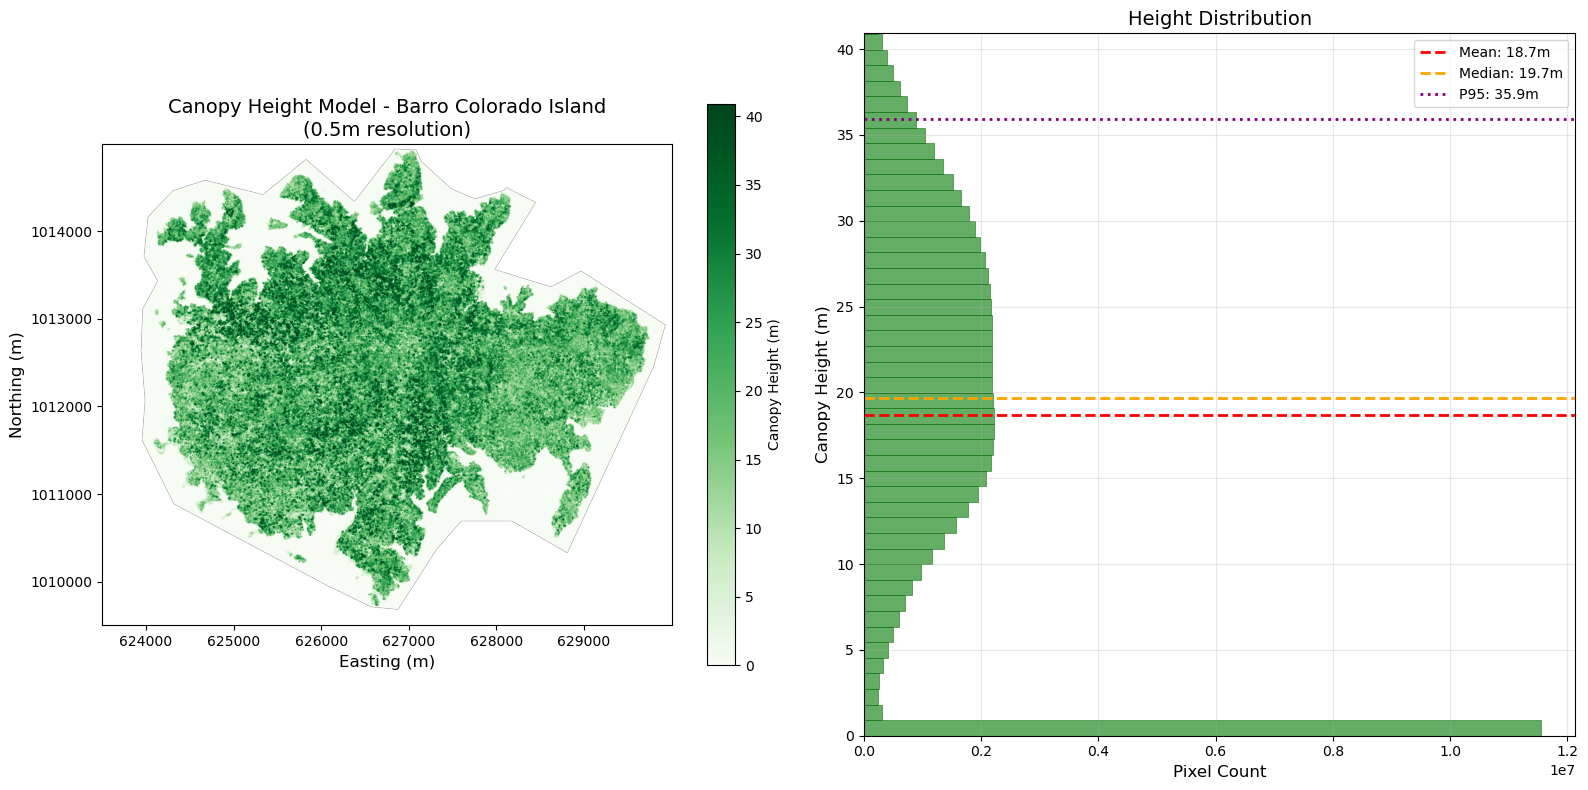

In [12]:
# Create custom colormap for tropical forest CHM
colors_tropical = [
    '#f7fcf5',  # Very light green (ground/gaps)
    '#c7e9c0',  # Light green (understory)
    '#74c476',  # Medium green (sub-canopy)
    '#31a354',  # Green (canopy)
    '#006d2c',  # Dark green (upper canopy)
    '#00441b'   # Very dark green (emergents)
]
tropical_cmap = LinearSegmentedColormap.from_list('tropical', colors_tropical, N=256)

# Create main visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. CHM Map
ax1 = axes[0]
# Get plot data and mask NoData
plot_data = chm_plot.values
if chm.rio.nodata is not None:
    plot_data = np.ma.masked_equal(plot_data, chm.rio.nodata)
plot_data = np.ma.masked_invalid(plot_data)

# Use percentile-based clipping for better visualization
vmin, vmax = 0, stats['percentiles']['p99']

im = ax1.imshow(plot_data, cmap=tropical_cmap, vmin=vmin, vmax=vmax,
                extent=[chm_plot.x.min(), chm_plot.x.max(), 
                        chm_plot.y.min(), chm_plot.y.max()])
ax1.set_xlabel('Easting (m)', fontsize=12)
ax1.set_ylabel('Northing (m)', fontsize=12)
ax1.set_title(f'Canopy Height Model - Barro Colorado Island\n(0.5m resolution)', fontsize=14)
ax1.ticklabel_format(style='plain')
cbar = plt.colorbar(im, ax=ax1, label='Canopy Height (m)', shrink=0.8)

# 2. Height histogram alongside
ax2 = axes[1]
ax2.hist(chm_heights, bins=80, color='forestgreen', alpha=0.7, 
         edgecolor='darkgreen', linewidth=0.5, orientation='horizontal')
ax2.axhline(stats['height_statistics']['mean_m'], color='red', linestyle='--', 
            linewidth=2, label=f"Mean: {stats['height_statistics']['mean_m']:.1f}m")
ax2.axhline(stats['height_statistics']['median_m'], color='orange', linestyle='--',
            linewidth=2, label=f"Median: {stats['height_statistics']['median_m']:.1f}m")
ax2.axhline(stats['percentiles']['p95'], color='purple', linestyle=':',
            linewidth=2, label=f"P95: {stats['percentiles']['p95']:.1f}m")
ax2.set_ylabel('Canopy Height (m)', fontsize=12)
ax2.set_xlabel('Pixel Count', fontsize=12)
ax2.set_title('Height Distribution', fontsize=14)
ax2.set_ylim(0, vmax)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
overview_path = OUTPUT_DIR / f"{SITE_NAME}_chm_overview.png"
plt.savefig(overview_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"Overview saved to: {overview_path.name}")

plt.show()

Emergent tree map saved to: bci_panama_emergent_trees.png


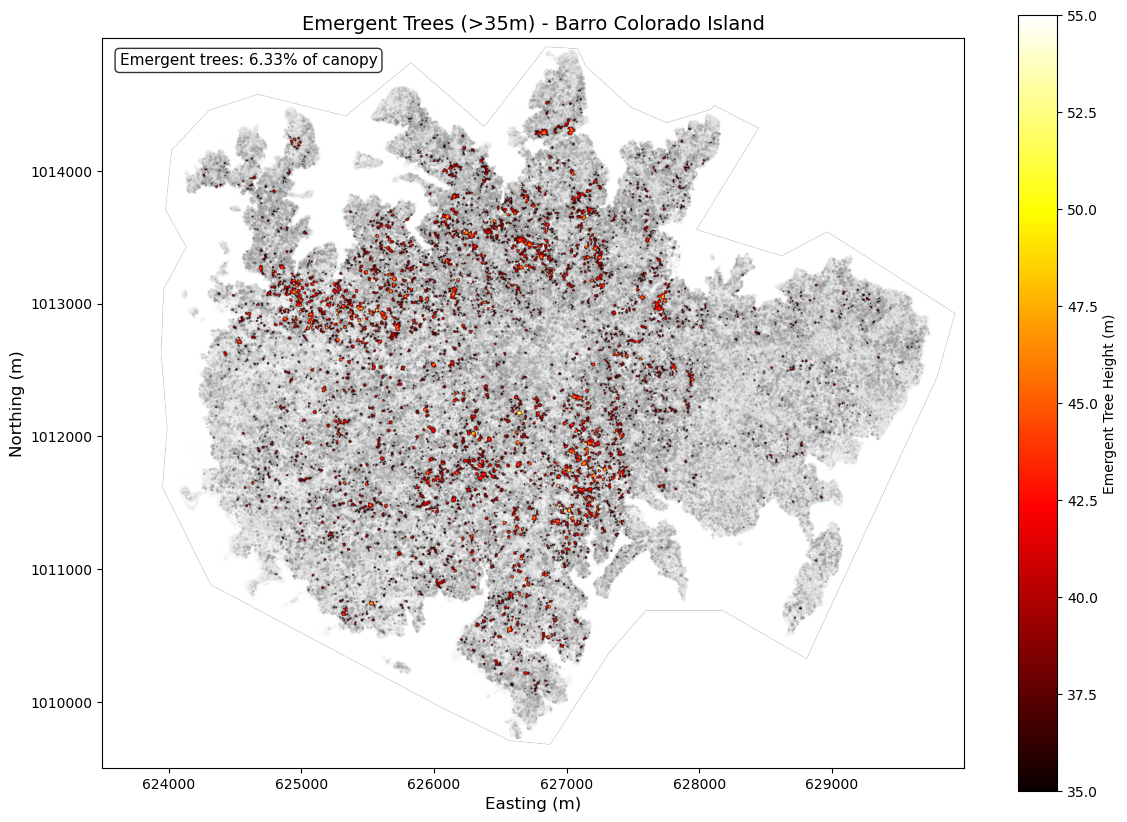

In [13]:
# Create high-contrast visualization showing emergent trees
fig, ax = plt.subplots(figsize=(12, 10))

# Threshold to highlight emergent trees (>35m)
emergent_threshold = 35

# Create masked data for emergents
plot_data_emergent = np.where(plot_data >= emergent_threshold, plot_data, np.nan)

# Base CHM in grayscale
im_base = ax.imshow(plot_data, cmap='Greys', vmin=0, vmax=50, alpha=0.7,
                    extent=[chm_plot.x.min(), chm_plot.x.max(), 
                            chm_plot.y.min(), chm_plot.y.max()])

# Overlay emergents in color
im_emergent = ax.imshow(plot_data_emergent, cmap='hot', vmin=35, vmax=55,
                        extent=[chm_plot.x.min(), chm_plot.x.max(), 
                                chm_plot.y.min(), chm_plot.y.max()])

ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
ax.set_title(f'Emergent Trees (>{emergent_threshold}m) - Barro Colorado Island', fontsize=14)
ax.ticklabel_format(style='plain')

cbar = plt.colorbar(im_emergent, ax=ax, label='Emergent Tree Height (m)', shrink=0.8)

# Count emergents
emergent_pct = 100 * np.sum(chm_heights >= emergent_threshold) / len(chm_heights)
ax.text(0.02, 0.98, f'Emergent trees: {emergent_pct:.2f}% of canopy', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Save
emergent_path = OUTPUT_DIR / f"{SITE_NAME}_emergent_trees.png"
plt.savefig(emergent_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"Emergent tree map saved to: {emergent_path.name}")

plt.show()

## 7. Data Quality Assessment

In [14]:
# Check for data quality issues
print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

quality_report = {
    'nodata_percentage': 100 * (len(chm_data) - len(chm_valid)) / len(chm_data),
    'negative_values': int(negative_count),
    'negative_percentage': 100 * negative_count / len(chm_valid) if len(chm_valid) > 0 else 0,
    'extreme_high_values': int(extreme_high),
    'extreme_high_percentage': 100 * extreme_high / len(chm_valid) if len(chm_valid) > 0 else 0,
}

print(f"\n1. NoData Coverage:")
print(f"   NoData pixels: {len(chm_data) - len(chm_valid):,}")
print(f"   Percentage: {quality_report['nodata_percentage']:.2f}%")
if quality_report['nodata_percentage'] > 20:
    print(f"   WARNING: High NoData percentage may indicate water bodies or scan gaps")

print(f"\n2. Negative Values (Artifacts):")
print(f"   Count: {quality_report['negative_values']:,}")
print(f"   Percentage: {quality_report['negative_percentage']:.4f}%")
if quality_report['negative_values'] > 0:
    neg_min = np.min(chm_valid[chm_valid < 0])
    print(f"   Minimum negative value: {neg_min:.2f} m")
    print(f"   NOTE: Negative values likely from DSM-DTM subtraction artifacts")

print(f"\n3. Extreme High Values (>{HEIGHT_MAX}m):")
print(f"   Count: {quality_report['extreme_high_values']:,}")
print(f"   Percentage: {quality_report['extreme_high_percentage']:.4f}%")
if quality_report['extreme_high_values'] > 0:
    max_val = np.max(chm_valid)
    print(f"   Maximum value: {max_val:.2f} m")
    if max_val > 100:
        print(f"   WARNING: Very high values may be artifacts or structures")

# Overall quality score
quality_score = 100 - quality_report['nodata_percentage'] - quality_report['negative_percentage'] - quality_report['extreme_high_percentage']
print(f"\n4. Overall Data Quality Score: {quality_score:.2f}%")
if quality_score >= 95:
    print("   EXCELLENT - Data is suitable for fractal analysis")
elif quality_score >= 85:
    print("   GOOD - Minor artifacts present, suitable for analysis")
elif quality_score >= 70:
    print("   FAIR - Some data quality issues, proceed with caution")
else:
    print("   POOR - Significant data quality issues")

stats['quality_assessment'] = quality_report
stats['quality_score'] = quality_score

DATA QUALITY ASSESSMENT

1. NoData Coverage:
   NoData pixels: 57,579,576
   Percentage: 40.27%

2. Negative Values (Artifacts):
   Count: 11,775,250
   Percentage: 13.7851%
   Minimum negative value: -54.64 m
   NOTE: Negative values likely from DSM-DTM subtraction artifacts

3. Extreme High Values (>80m):
   Count: 0
   Percentage: 0.0000%

4. Overall Data Quality Score: 45.95%
   POOR - Significant data quality issues


Quality assessment saved to: bci_panama_data_quality.png


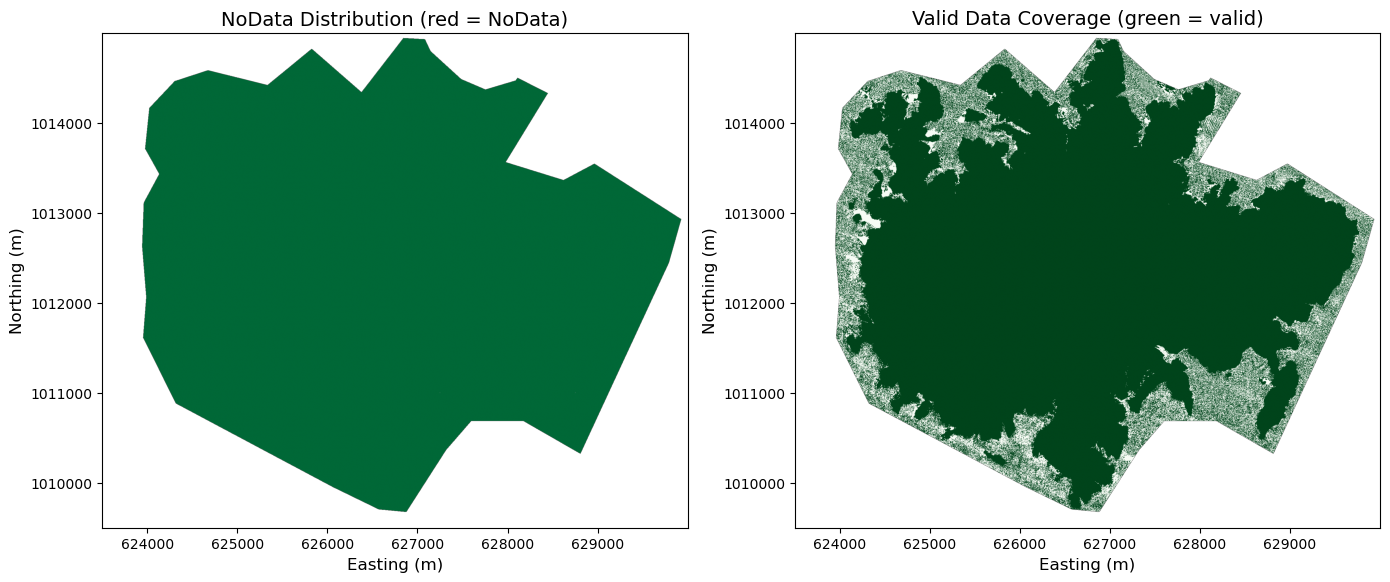

In [15]:
# Visualize NoData distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. NoData mask
ax1 = axes[0]
nodata_mask = np.isnan(plot_data) | (plot_data == chm.rio.nodata if chm.rio.nodata else False)
ax1.imshow(nodata_mask, cmap='RdYlGn_r', 
           extent=[chm_plot.x.min(), chm_plot.x.max(), 
                   chm_plot.y.min(), chm_plot.y.max()])
ax1.set_xlabel('Easting (m)', fontsize=12)
ax1.set_ylabel('Northing (m)', fontsize=12)
ax1.set_title('NoData Distribution (red = NoData)', fontsize=14)
ax1.ticklabel_format(style='plain')

# 2. Valid data coverage
ax2 = axes[1]
valid_mask = ~nodata_mask & (plot_data >= 0) & (plot_data <= HEIGHT_MAX)
ax2.imshow(valid_mask, cmap='Greens',
           extent=[chm_plot.x.min(), chm_plot.x.max(), 
                   chm_plot.y.min(), chm_plot.y.max()])
ax2.set_xlabel('Easting (m)', fontsize=12)
ax2.set_ylabel('Northing (m)', fontsize=12)
ax2.set_title('Valid Data Coverage (green = valid)', fontsize=14)
ax2.ticklabel_format(style='plain')

plt.tight_layout()

# Save
quality_path = OUTPUT_DIR / f"{SITE_NAME}_data_quality.png"
plt.savefig(quality_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"Quality assessment saved to: {quality_path.name}")

plt.show()

## 8. Comparison with Published BCI Data

In [16]:
# Compare with published BCI forest structure data
print("="*60)
print("COMPARISON WITH PUBLISHED BCI DATA")
print("="*60)

# Published values from BCI 50-ha plot studies
published = {
    'mean_canopy_height_m': 20,  # Approximate from various studies
    'max_emergent_height_m': 50,  # Tallest emergents ~45-55m
    'canopy_gap_fraction': 0.02,  # ~2% gaps at any time
    'tree_density_per_ha': 420,  # ~420 trees/ha (>10cm DBH)
    'species_richness': 300,  # ~300 tree species
}

print(f"\nPublished BCI forest metrics (literature values):")
print(f"  Mean canopy height: ~{published['mean_canopy_height_m']} m")
print(f"  Maximum emergent height: ~{published['max_emergent_height_m']} m")
print(f"  Tree density: ~{published['tree_density_per_ha']} trees/ha (>10cm DBH)")
print(f"  Species richness: ~{published['species_richness']} tree species")

print(f"\nThis CHM analysis:")
print(f"  Mean height: {stats['height_statistics']['mean_m']:.1f} m")
print(f"  P99 height (near-max emergents): {stats['percentiles']['p99']:.1f} m")
print(f"  Maximum recorded: {stats['height_statistics']['max_m']:.1f} m")

# Calculate gap fraction (pixels < 2m height)
gap_fraction = np.sum(chm_heights < 2) / len(chm_heights)
print(f"  Estimated gap fraction (<2m): {100*gap_fraction:.2f}%")

print(f"\nValidation:")
if abs(stats['height_statistics']['mean_m'] - published['mean_canopy_height_m']) < 10:
    print(f"  Mean height: CONSISTENT with published data")
else:
    print(f"  Mean height: DIFFERS from published data (may include understory)")

if stats['percentiles']['p99'] <= published['max_emergent_height_m'] + 5:
    print(f"  Max emergent height: CONSISTENT with published data")
else:
    print(f"  Max emergent height: HIGHER than expected (check for artifacts)")

stats['published_comparison'] = published
stats['gap_fraction'] = float(gap_fraction)

COMPARISON WITH PUBLISHED BCI DATA

Published BCI forest metrics (literature values):
  Mean canopy height: ~20 m
  Maximum emergent height: ~50 m
  Tree density: ~420 trees/ha (>10cm DBH)
  Species richness: ~300 tree species

This CHM analysis:
  Mean height: 18.7 m
  P99 height (near-max emergents): 40.9 m
  Maximum recorded: 72.7 m
  Estimated gap fraction (<2m): 16.17%

Validation:
  Mean height: CONSISTENT with published data
  Max emergent height: CONSISTENT with published data


## 9. Save Metadata and Summary

In [ ]:
# Save comprehensive metadata
metadata_path = OUTPUT_DIR / f"{SITE_NAME}_chm_metadata.json"

with open(metadata_path, 'w') as f:
    json.dump(stats, f, indent=2)

print(f"Metadata saved to: {metadata_path}")
print(f"\nFile contains:")
for key in stats.keys():
    print(f"  - {key}")

In [ ]:
# Generate thumbnail for quick reference
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(plot_data, cmap=tropical_cmap, vmin=0, vmax=stats['percentiles']['p99'])
ax.set_title(f'BCI CHM - {stats["height_statistics"]["mean_m"]:.1f}m mean', fontsize=14)
ax.axis('off')
plt.colorbar(im, ax=ax, label='Height (m)', shrink=0.8)

plt.tight_layout()

thumb_path = OUTPUT_DIR / f"{SITE_NAME}_chm_thumbnail.png"
plt.savefig(thumb_path, dpi=100, bbox_inches='tight', facecolor='white')
print(f"Thumbnail saved to: {thumb_path.name}")

plt.show()

In [ ]:
# Final summary
print("\n" + "="*60)
print("CHM EXPLORATION COMPLETE")
print("="*60)

print(f"\nSite: {SITE_DESCRIPTION}")
print(f"Resolution: {stats['resolution_m']}m")
print(f"Area: {stats['area_km2']:.2f} km²")

print(f"\nKey Statistics:")
print(f"  Mean height:   {stats['height_statistics']['mean_m']:.2f} m")
print(f"  Median height: {stats['height_statistics']['median_m']:.2f} m")
print(f"  Max height:    {stats['height_statistics']['max_m']:.2f} m")
print(f"  Std deviation: {stats['height_statistics']['std_m']:.2f} m")

print(f"\nData Quality Score: {stats['quality_score']:.1f}%")

print(f"\nOutput Files:")
for f in OUTPUT_DIR.glob(f"{SITE_NAME}*"):
    print(f"  - {f.name}")

print(f"\nReady for fractal analysis!")
print(f"Use CHM_PATH = '{CHM_PATH}'")

## 10. Cleanup

In [ ]:
# Free memory
chm.close()
del chm, chm_plot, chm_data, chm_valid, chm_heights, plot_data

import gc
gc.collect()

print("Memory cleaned up.")

---

## References

1. **Smithsonian ALS Panama 2023:** https://smithsonian.dataone.org/datasets/ALS_Panama_2023/
2. **BCI 50-ha Plot:** Hubbell, S.P. & Foster, R.B. (1983) - Diversity in the tropical rain forest
3. **BCI Forest Dynamics:** https://forestgeo.si.edu/sites/neotropics/barro-colorado-island
4. **3DEP Workflow Framework:** Adapted from fractal-notebooks/docs/notebooks/3dep/